# Imports

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

# The Inverse Problem

## Problem Statement

Here, we'll use the PDE used above:

$$
\frac{d}{dx}\left(E(x)A(x)\frac{d}{dx}u(x)\right) +p(x) = 0
$$

to get the value of $EA(x)$ assuming that we know the solution. We'll use the same neural network architecture as above.

The differential equation becomes:
$$
E(x)u_{xx} + E_x(x)u_x + p(x) = 0
$$

now define:

$$
f:=E(x)u_{xx} + E_x(x)u_x + p(x)
$$

We already know $u$, $u_x$ and $u_{xx}$, so we will create a neural network to approximate $E(x)$.

>Please note that I've dropped the A, it is assumed to be absorbed in the E.

The analytical form of the functions are:
$$
\begin{aligned}
u(x) &= \sin(2\pi x)\\
u_x(x) &= 2\pi\cos(2\pi x)\\
u_{xx}(x) &= -4\pi^2\sin(2\pi x)
\end{aligned}
$$

while, we choose the following form for $E(x)$:
$$
E(x) = x^2 - x^2 +1
$$

For this, the load function becomes:

$$
p(x) = -2(3x^2 - 2x)\pi \cos(2\pi x) + 4(x^3 - x^2 + 1)\pi ^2\sin(2\pi x)
$$

## Solution

Once again, we'll start by defining some variables:

In [12]:
#The function u(x) = sin(2*pi*x)
u_analytical = lambda x: torch.sin(2*torch.pi * x)
E_analytical = lambda x: x**3 - x**2 + 1

#The load function f(x) = 4*pi^2*sin(2*pi*x)
p = lambda x: -2*(3*x**2 - 2*x)*torch.pi*torch.cos(2*torch.pi*x) + 4*(x**3 - x**2 + 1)*torch.pi**2*torch.sin(2*torch.pi*x)

In [13]:
def collocation_points(points):
    #Create a tensor of collocation points
    x = torch.linspace(0, 1, points, requires_grad=True, dtype=torch.float32) #requires_grad=True to compute the gradient
    return x

X_c = collocation_points(100)
# u_c = u_analytical(X_c)
# inputs = torch.zeros((100, 2), dtype=torch.float32)
# inputs[:, 0] = X_c
# inputs[:, 1] = u_c
inputs = X_c.unsqueeze(1)
inputs.shape

torch.Size([100, 1])

We'll define the cost function here. It will take input and the model and will return the residuals.

In [14]:
def loss(inputs, model):
    e = model(inputs)
    e_x = torch.autograd.grad(e, inputs, grad_outputs=torch.ones_like(e), create_graph=True, retain_graph=True)[0]
    
    u = u_analytical(inputs)
    u_x = torch.autograd.grad(u, inputs, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, inputs, grad_outputs=torch.ones_like(u_x), create_graph=True,  retain_graph=True)[0]

    l = torch.mean((e*u_xx + e_x*u_x + p(inputs))**2)
    return l

In [15]:
model = nn.Sequential(
    nn.Linear(1, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
)

In [16]:
#create a LBFGS optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=1000, max_eval=100, tolerance_grad=1e-05, tolerance_change=1e-06)

In [17]:
epochs = 20
losses = []
for epoch in range(epochs):
    u = model(inputs)
    loss_ = loss(inputs, model)
    optimizer.zero_grad()
    loss_.backward()
    def closure():
        optimizer.zero_grad()
        loss_ = loss(inputs, model)
        loss_.backward()
        return loss_
    optimizer.step(closure=closure)
    losses.append(loss_.item())

    print(f"Epoch {epoch+1:>4d}/{epochs} | loss={loss_.item():.4f}")


Epoch    1/20 | loss=488.6730
Epoch    2/20 | loss=1.8172
Epoch    3/20 | loss=0.0110
Epoch    4/20 | loss=0.0026
Epoch    5/20 | loss=0.0013
Epoch    6/20 | loss=0.0007
Epoch    7/20 | loss=0.0002
Epoch    8/20 | loss=0.0000
Epoch    9/20 | loss=0.0000
Epoch   10/20 | loss=0.0000
Epoch   11/20 | loss=0.0000
Epoch   12/20 | loss=0.0000
Epoch   13/20 | loss=0.0000
Epoch   14/20 | loss=0.0000
Epoch   15/20 | loss=0.0000
Epoch   16/20 | loss=0.0000
Epoch   17/20 | loss=0.0000
Epoch   18/20 | loss=0.0000
Epoch   19/20 | loss=0.0000
Epoch   20/20 | loss=0.0000


Let's plot the value of $E(x)$:

In [18]:
E_true = E_analytical(X_c)
E_model = model(X_c.unsqueeze(1))

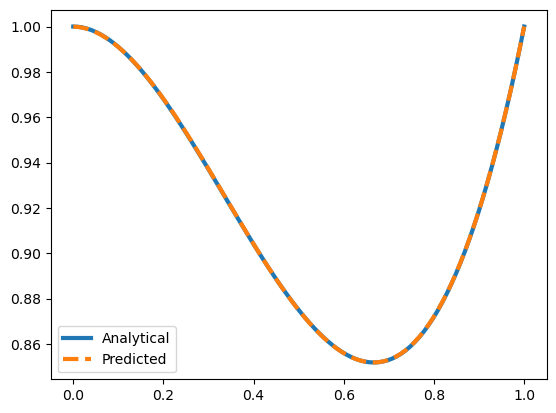

In [19]:
plt.plot(X_c.detach().numpy(), E_true.detach().numpy(), label="Analytical", lw=3)
plt.plot(X_c.detach().numpy(), E_model.detach().numpy(), label="Predicted", linestyle="--", lw=3)
plt.legend()
plt.savefig(os.path.join("plots", "0201.png"))
plt.show()

Let's plot the loss.

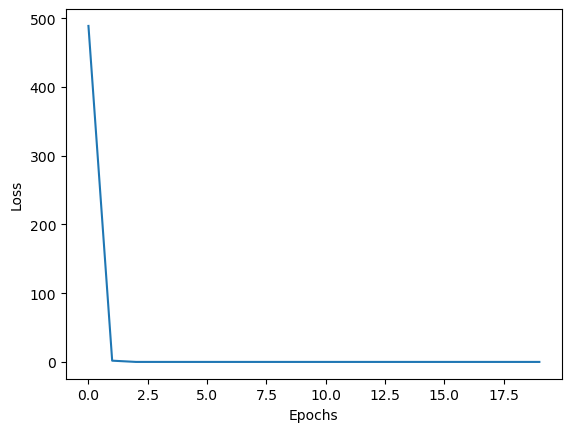

In [20]:
#plot losses
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(os.path.join("plots", "0202.png"))
plt.show()